In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass


ERROR:root:Line magic function `%tensorflow_version` not found.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
%matplotlib inline

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 535ms/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 46ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 43ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 46ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 43ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 0s 40ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 38ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 40ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 47ms/step - loss: 16.7104 - mae: 17.2282
Epoch 88/100
8/8 [==============================] - 0s 44ms/step - loss: 18.4311 - mae: 18.9970
Epoch 89/100
8/8 [==============================] - 0s 42ms/step - loss: 16.0676 - mae: 15.9963
Epoch 90/100
8/8 [==============================] - 0s 43ms/step - loss: 25.1790 - mae: 25.8227
Epoch 91/100
8/8 [==============================] - 0s 50ms/step - loss: 22.2115 - mae: 22.4735
Epoch 92/100
8/8 [==============================] - 0s 47ms/step - loss: 17.8038 - mae: 18.2060
Epoch 93/100
8/8 [==============================] - 0s 46ms/step - loss: 14.0547 - mae: 14.1759
Epoch 94/100
8/8 [==============================] - 0s 42ms/step - loss: 17.5642 - mae: 18.2202
Epoch 95/100
8/8 [==============================] - 0s 39ms/step - loss: 15.9512 - mae: 16.4590
Epoch 96/100
8/8 [==============================] - 0s 42ms/step - loss: 20.2822 - mae: 20.7799
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

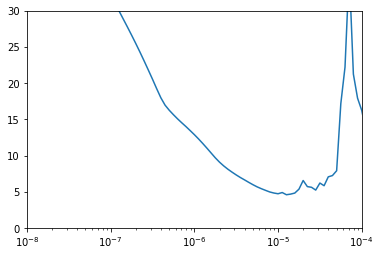

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 2s 71ms/step - loss: 21.5797 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 1s 19ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 1s 18ms/step - loss: 6.6407 - mae: 7.1331
Epoch 4/500
31/31 [==============================] - 1s 19ms/step - loss: 6.1320 - mae: 6.6106
Epoch 5/500
31/31 [==============================] - 1s 17ms/step - loss: 5.8183 - mae: 6.3067
Epoch 6/500
31/31 [==============================] - 1s 17ms/step - loss: 5.5784 - mae: 6.0627
Epoch 7/500
31/31 [==============================] - 1s 18ms/step - loss: 5.4629 - mae: 5.9432
Epoch 8/500
31/31 [==============================] - 1s 20ms/step - loss: 5.3205 - mae: 5.7958
Epoch 9/500
31/31 [==============================] - 1s 18ms/step - loss: 5.2130 - mae: 5.7055
Epoch 10/500
31/31 [==============================] - 1s 16ms/step - loss: 5.2043 - mae: 5.6914
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 17ms/step - loss: 4.3709 - mae: 4.8492
Epoch 87/500
31/31 [==============================] - 0s 16ms/step - loss: 4.2630 - mae: 4.7396
Epoch 88/500
31/31 [==============================] - 1s 16ms/step - loss: 4.3082 - mae: 4.7822
Epoch 89/500
31/31 [==============================] - 1s 17ms/step - loss: 4.2192 - mae: 4.7058
Epoch 90/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2286 - mae: 4.6989
Epoch 91/500
31/31 [==============================] - 1s 18ms/step - loss: 4.2334 - mae: 4.7087
Epoch 92/500
31/31 [==============================] - 1s 17ms/step - loss: 4.2484 - mae: 4.7295
Epoch 93/500
31/31 [==============================] - 1s 16ms/step - loss: 4.2334 - mae: 4.7061
Epoch 94/500
31/31 [==============================] - 1s 17ms/step - loss: 4.2288 - mae: 4.6938
Epoch 95/500
31/31 [==============================] - 0s 16ms/step - loss: 4.3070 - mae: 4.7843
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 17ms/step - loss: 4.1151 - mae: 4.5896
Epoch 171/500
31/31 [==============================] - 1s 17ms/step - loss: 4.2500 - mae: 4.7167
Epoch 172/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1223 - mae: 4.6017
Epoch 173/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1602 - mae: 4.6304
Epoch 174/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1104 - mae: 4.5804
Epoch 175/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1058 - mae: 4.5811
Epoch 176/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1275 - mae: 4.5943
Epoch 177/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1366 - mae: 4.6072
Epoch 178/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1308 - mae: 4.5954
Epoch 179/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1136 - mae: 4.5821
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 20ms/step - loss: 4.0447 - mae: 4.5182
Epoch 255/500
31/31 [==============================] - 1s 20ms/step - loss: 4.0313 - mae: 4.5064
Epoch 256/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1190 - mae: 4.5969
Epoch 257/500
31/31 [==============================] - 1s 18ms/step - loss: 4.0967 - mae: 4.5778
Epoch 258/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1056 - mae: 4.5797
Epoch 259/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0854 - mae: 4.5537
Epoch 260/500
31/31 [==============================] - 1s 17ms/step - loss: 4.0438 - mae: 4.5205
Epoch 261/500
31/31 [==============================] - 1s 18ms/step - loss: 4.1071 - mae: 4.5713
Epoch 262/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1496 - mae: 4.6295
Epoch 263/500
31/31 [==============================] - 1s 17ms/step - loss: 4.1110 - mae: 4.5792
Epoch 264/500
31/31 [=======================

Epoch 338/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0149 - mae: 4.4837
Epoch 339/500
31/31 [==============================] - 1s 17ms/step - loss: 3.9943 - mae: 4.4706
Epoch 340/500
31/31 [==============================] - 0s 16ms/step - loss: 3.9834 - mae: 4.4579
Epoch 341/500
31/31 [==============================] - 1s 17ms/step - loss: 4.0568 - mae: 4.5187
Epoch 342/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0651 - mae: 4.5490
Epoch 343/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0202 - mae: 4.4933
Epoch 344/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0251 - mae: 4.4959
Epoch 345/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0359 - mae: 4.5139
Epoch 346/500
31/31 [==============================] - 1s 16ms/step - loss: 4.0244 - mae: 4.4972
Epoch 347/500
31/31 [==============================] - 0s 16ms/step - loss: 3.9785 - mae: 4.4500
Epoch 348/500
31/31 [=========

31/31 [==============================] - 1s 16ms/step - loss: 3.9416 - mae: 4.4093
Epoch 423/500
31/31 [==============================] - 0s 16ms/step - loss: 3.9603 - mae: 4.4308
Epoch 424/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9546 - mae: 4.4207
Epoch 425/500
31/31 [==============================] - 1s 17ms/step - loss: 3.9531 - mae: 4.4199
Epoch 426/500
31/31 [==============================] - 1s 16ms/step - loss: 3.9658 - mae: 4.4421
Epoch 427/500
31/31 [==============================] - 1s 16ms/step - loss: 3.9521 - mae: 4.4284
Epoch 428/500
31/31 [==============================] - 1s 17ms/step - loss: 3.9839 - mae: 4.4620
Epoch 429/500
31/31 [==============================] - 1s 17ms/step - loss: 3.9369 - mae: 4.4128
Epoch 430/500
31/31 [==============================] - 1s 17ms/step - loss: 3.9430 - mae: 4.4131
Epoch 431/500
31/31 [==============================] - 1s 18ms/step - loss: 3.9967 - mae: 4.4719
Epoch 432/500
31/31 [=======================

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

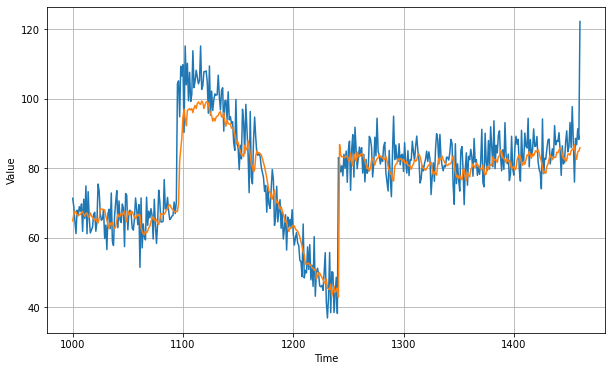

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0791225

<Figure size 432x288 with 0 Axes>

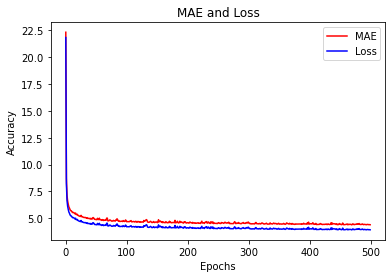

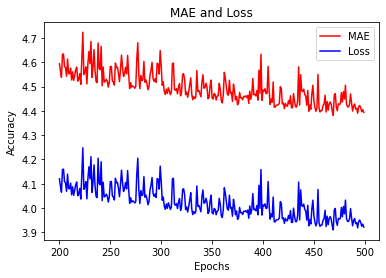

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()